# Creating word2vec model using Gensim

In [1]:
# Loading dependencies
!pip install -q gensim
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
/tools/node/lib
└─┬ localtunnel@1.9.0 
  ├─┬ axios@0.17.1 
  │ ├─┬ follow-redirects@1.5.0 
  │ │ └── debug@3.1.0 
  │ └── is-buffer@1.1.6 
  ├─┬ debug@2.6.8 
  │ └── ms@2.0.0 
  ├── openurl@1.1.1 
  └─┬ yargs@6.6.0 
    ├── camelcase@3.0.0 
    ├─┬ cliui@3.2.0 
    │ ├─┬ strip-ansi@3.0.1 
    │ │ └── ansi-regex@2.1.1 
    │ └── wrap-ansi@2.1.0 
    ├── decamelize@1.2.0 
    ├── get-caller-file@1.0.2 
    ├─┬ os-locale@1.4.0 
    │ └─┬ lcid@1.0.0 
    │   └── invert-kv@1.0.0 
    ├─┬ read-pkg-up@1.0.1 
    │ ├─┬ find-up@1.1.2 
    │ │ ├── path-exists@2.1.0 
    │ │ └─┬ pinkie-promise@2.0.1 
    │ │   └── pinkie@2.0.4 
    │ └─┬ read-pkg@1.1.0 
    │   ├─┬ load-json-file@1.1.0 
    │   │ ├── graceful-fs@4.1.11 
    │   │ ├─┬ parse-json@2.2.0 
    │   │ │ └─┬ error-ex@1.3.1 
    │   │ │   └── is-arrayish@0.2.1 
    │   │ ├── pify@2.3.0 
    │   │ └─┬ strip-bom@2.0.0 
    │   │   └── is-utf8@0.2.1 
    │   ├─┬ normal

In [0]:
from __future__ import absolute_import, division, print_function


import multiprocessing
import os , json , requests
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

In [3]:
"""**Download NLTK tokenizer models (only the first time)**"""

nltk.download("punkt")
nltk.download("stopwords")


[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
"""## Prepare Corpus

**Load books from url**
"""
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return map(lambda x:x.lower(),words)
  
filepath = 'http://www.gutenberg.org/files/33224/33224-0.txt'

corpus_raw = requests.get(filepath).text

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

raw_sentences = tokenizer.tokenize(corpus_raw)


#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))
        
        
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 425,633 tokens


In [6]:
 """## Train Word2Vec"""
    
# Dimensionality of the resulting word vectors more dimensions, more computationally expensive to train but also more accurate
# more dimensions = more generalized

num_features = 300

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.

#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1


client2vec = w2v.Word2Vec(
            sg=1,
            seed=seed,
            workers=num_workers,
            size=num_features,
            min_count=min_word_count,
            window=context_size,
            sample=downsampling
        )
        
client2vec.build_vocab(sentences)

client2vec.corpus_count
    

18225

In [0]:
"""**Start training, this might take a minute or two...**"""

client2vec.train(sentences ,total_examples=client2vec.corpus_count , epochs=10)

"""**Save to file, can be useful later**"""

if not os.path.exists(os.path.join("trained",'sample')):
    os.makedirs(os.path.join("trained",'sample'))

client2vec.save(os.path.join("trained",'sample', ".w2v"))



In [12]:
client2vec.most_similar("earth")


client2vec.most_similar_cosmul(positive=['moon','earth'], negative=['orbit'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  


[(u'rays', 1.208323359489441),
 (u'moon', 1.1763640642166138),
 (u'orbit', 1.1260943412780762),
 (u'fluids', 1.1146817207336426),
 (u'centre', 1.1031447649002075),
 (u'inequalities', 1.0925137996673584),
 (u'crust', 1.0897741317749023),
 (u'motion', 1.0614211559295654),
 (u'outwards', 1.057884931564331),
 (u'axis', 1.0563626289367676)]

# **Making Word cluster plot**

In [0]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

all_word_vectors_matrix = client2vec.wv.vectors




all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[client2vec.wv.vocab[word].index])
            for word in client2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [10]:
points.head(10)

,word,x,y
0,writings,29.629522,-38.974300
1,grossier,10.222187,5.775322
2,yellow,-40.589222,29.824379
3,four,9.690726,66.592163
4,woods,-3.055601,24.224417
5,preface,25.053215,-28.383905
6,woody,7.314858,46.364746
7,increase,-29.728304,-38.187218
8,granting,-15.522632,-29.961544
9,electricity,-36.729168,-35.492916


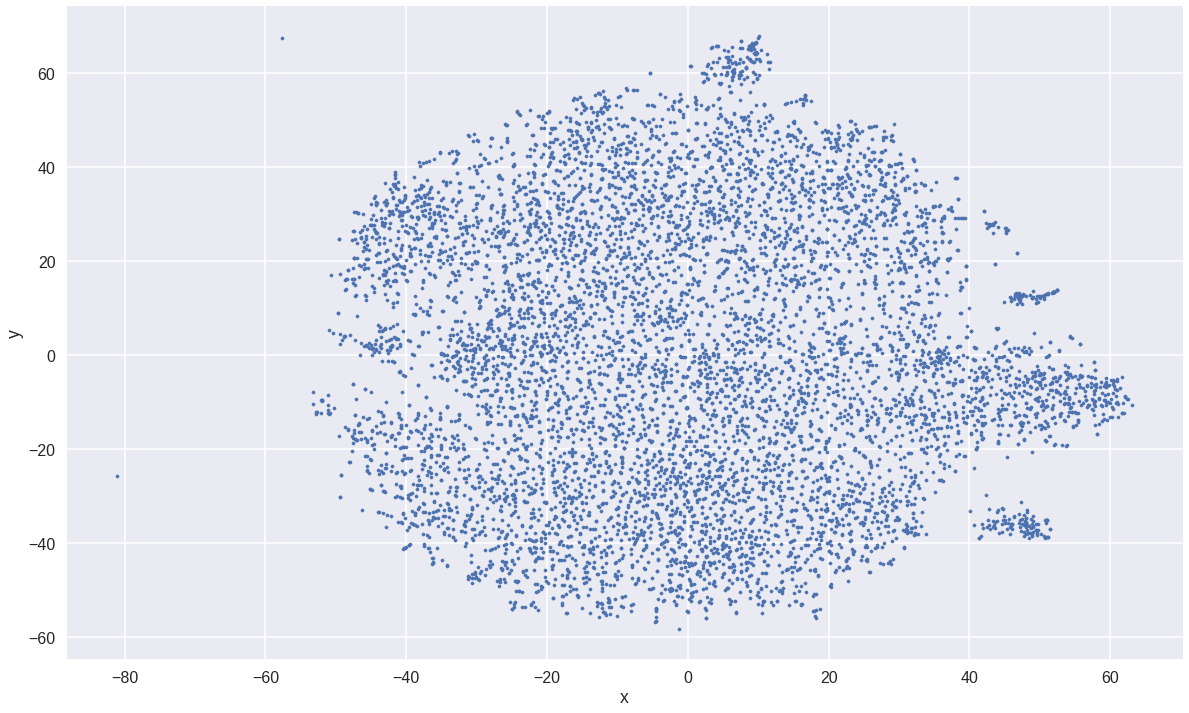

In [11]:
sns.set_context("poster")
    
ax = points.plot.scatter("x", "y", s=10, figsize=(20, 12))


fig = ax.get_figure()
fig.savefig(os.path.join("trained",'sample'+".png"))

In [0]:
def plot_region(x_bounds, y_bounds):
        slice = points[
            (x_bounds[0] <= points.x) &
            (points.x <= x_bounds[1]) & 
            (y_bounds[0] <= points.y) &
            (points.y <= y_bounds[1])
        ]
        
        ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
        for i, point in slice.iterrows():
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

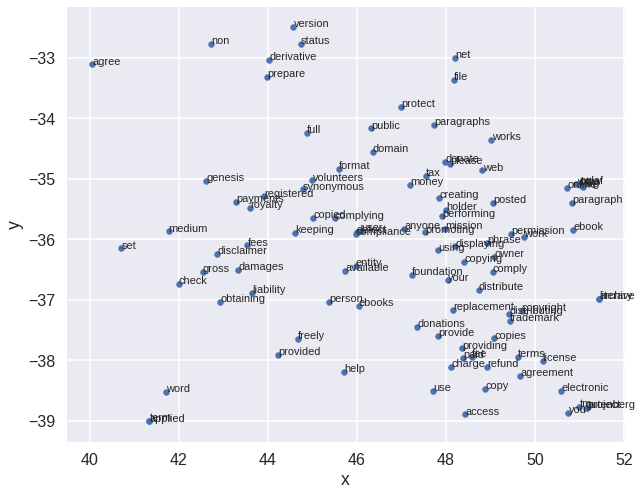

In [13]:
plot_region(x_bounds=(40.0, 60.0), y_bounds=(-40.0, -32.0))

In [15]:
client2vec.predict_output_word(['earth','orbit'])

[(u's', 0.007669124),
 (u'crust', 0.004008524),
 (u'inequalities', 0.002415759),
 (u'surface', 0.0022090022),
 (u'rotation', 0.0017914125),
 (u'orbit', 0.0016490074),
 (u'sun', 0.0016244925),
 (u'interior', 0.0014719291),
 (u'reduce', 0.0014188427),
 (u'axis', 0.0013258264)]

# **Creating Tensorboard vizualization**

In [0]:
vocab_list = points.word.values.tolist()
embeddings = all_word_vectors_matrix


embedding_var = tf.Variable(all_word_vectors_matrix, dtype='float32', name='embedding')
projector_config = projector.ProjectorConfig()


embedding = projector_config.embeddings.add()
embedding.tensor_name = embedding_var.name

LOG_DIR='./'
metadata_file = os.path.join("sample.tsv")



with open(os.path.join(LOG_DIR, metadata_file), 'wt') as metadata:
    metadata.writelines("%s\n" % w.encode('utf-8') for w in vocab_list)

embedding.metadata_path =  os.path.join(os.getcwd(), metadata_file)

# Use the same LOG_DIR where you stored your checkpoint.
summary_writer = tf.summary.FileWriter(LOG_DIR)

# The next line writes a projector_config.pbtxt in the LOG_DIR. TensorBoard will
# read this file during startup.
projector.visualize_embeddings(summary_writer, projector_config)

saver = tf.train.Saver([embedding_var])

with tf.Session() as sess:
    # Initialize the model
    sess.run(tf.global_variables_initializer())

    saver.save(sess, os.path.join(LOG_DIR, metadata_file+'.ckpt'))

In [17]:
LOG_DIR = './'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')
! cat url.txt


your url is: https://fluffy-vampirebat-3.localtunnel.me
